In [29]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../datasets/activemq-5.0.0.csv')
df = df.drop(columns=['HeuBug', 'HeuBugCount', 'RealBugCount'])

### Split Train/Test 80/20

In [30]:
# split train and test
from sklearn.model_selection import train_test_split

X = df.drop(columns=['RealBug'])
y = df['RealBug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64'])

In [31]:
print(X_train_numeric.shape)
print(X_test_numeric.shape)

(1507, 65)
(377, 65)


## Balanceo de clases usando HCBOU

### Configuración de hiperparámetros HCBOU

In [32]:
import sys
sys.path.append('../utils')

%load_ext autoreload
%autoreload 2
from hcbou import hcbou_balance, get_recommended_params

print("="*50)

# Obtener parámetros recomendados para nuestro dataset
recommended_params = get_recommended_params(X_train_numeric, y_train, scenario='binary_classification')
print(f"Parámetros recomendados: {recommended_params}")

X_train_balanced, y_train_balanced = hcbou_balance(
    X_train_numeric, 
    y_train,
    **recommended_params,
    random_state=42,
    verbose=True
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Parámetros recomendados: {'max_clusters_maj': 8, 'max_clusters_min': 6, 'k_smote': 3, 'min_cluster_obs': 5}
🚀 HCBOU BALANCING PIPELINE
Original distribution:
  Majority class (False): 1273 samples
  Minority class (True): 234 samples
  Imbalance ratio: 1:5.44

📉 Step 1: Majority Class Undersampling
----------------------------------------
Applying majority class undersampling...
Majority class: 1273 -> 753 samples
Reduction: 59.2%

📈 Step 2: Minority Class Clustering & SMOTE
---------------------------------------------
Finding optimal clusters for minority class...
No valid clusters found. Using single cluster.
Applying SMOTE balancing to minority class...
Cluster distribution: {0: 234}
Cluster weights: {0: 1.0}
Cluster 0: 234 -> 753 samples
Minority class: 234 -> 753 samples
Change: 321.8%

🔄 Step 3: Combining Balanced Classes
-----------------------------------

✅ HCBOU BALANCING COMPLETED
Final 

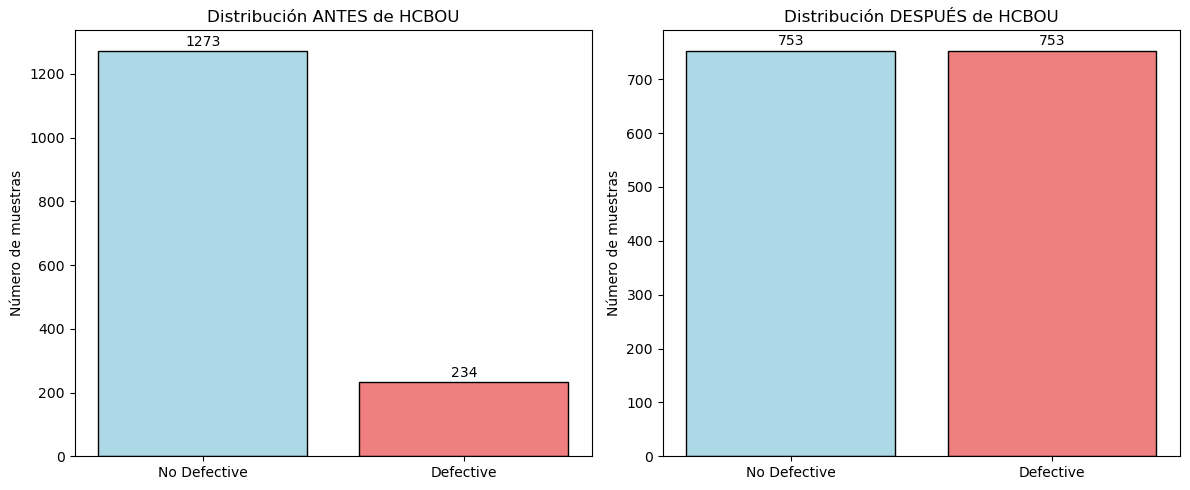


Verificación de calidad de datos balanceados:
Valores nulos en X_train_balanced: 0
Valores infinitos en X_train_balanced: 0
Shape final X_train_balanced: (1506, 65)
Shape final y_train_balanced: (1506,)


In [33]:
# Visualización de la distribución antes y después del balanceo
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Antes del balanceo
before_counts = y_train.value_counts().sort_index()
bars1 = ax1.bar(['No Defective', 'Defective'], before_counts.values, 
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax1.set_title('Distribución ANTES de HCBOU')
ax1.set_ylabel('Número de muestras')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Después del balanceo
after_counts = y_train_balanced.value_counts().sort_index()
bars2 = ax2.bar(['No Defective', 'Defective'], after_counts.values,
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax2.set_title('Distribución DESPUÉS de HCBOU')
ax2.set_ylabel('Número de muestras')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Verificar que no hay valores nulos en los datos balanceados
print(f"\nVerificación de calidad de datos balanceados:")
print(f"Valores nulos en X_train_balanced: {X_train_balanced.isnull().sum().sum()}")
print(f"Valores infinitos en X_train_balanced: {np.isinf(X_train_balanced.values).sum()}")
print(f"Shape final X_train_balanced: {X_train_balanced.shape}")
print(f"Shape final y_train_balanced: {y_train_balanced.shape}")

### Normalización

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_balanced_scaled = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns=X_train_balanced.columns, index=X_train_balanced.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_numeric), columns=X_test_numeric.columns, index=X_test_numeric.index)

In [35]:
X_train_balanced.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,...,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000
mean,0.431607,7.332669,197.716467,3.953519,0.880478,1.062417,0.780212,26.306773,1.583665,9.907703,...,3.632138,1.359230,80.662019,70.032537,0.719544,0.852617,0.000664,1.922975,1.357902,0.307437
std,1.362394,5.611470,223.896375,4.084550,3.544542,0.349782,1.759313,34.101278,0.927956,7.649384,...,2.689243,0.526164,124.977056,115.396993,0.169737,0.172619,0.025768,0.711120,0.523273,0.588176
min,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.340000,0.333333,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,73.000000,1.000000,0.000000,1.000000,0.000000,6.000000,1.000000,5.000000,...,2.000000,1.000000,13.000000,11.000000,0.572741,0.699178,0.000000,1.000000,1.000000,0.000000
50%,0.000000,6.000000,130.000000,3.000000,0.000000,1.000000,0.000000,13.000000,1.000000,8.000000,...,3.000000,1.000000,38.000000,32.500000,0.702977,0.976764,0.000000,2.000000,1.000000,0.000000
75%,0.000000,9.000000,247.750000,5.000000,0.000000,1.000000,1.000000,36.000000,2.000000,12.000000,...,5.000000,2.000000,98.750000,77.000000,0.852092,1.000000,0.000000,2.000000,2.000000,0.000000
max,21.000000,63.000000,2075.000000,56.000000,44.000000,4.000000,20.000000,301.000000,14.000000,75.000000,...,23.000000,4.000000,1402.000000,1326.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000


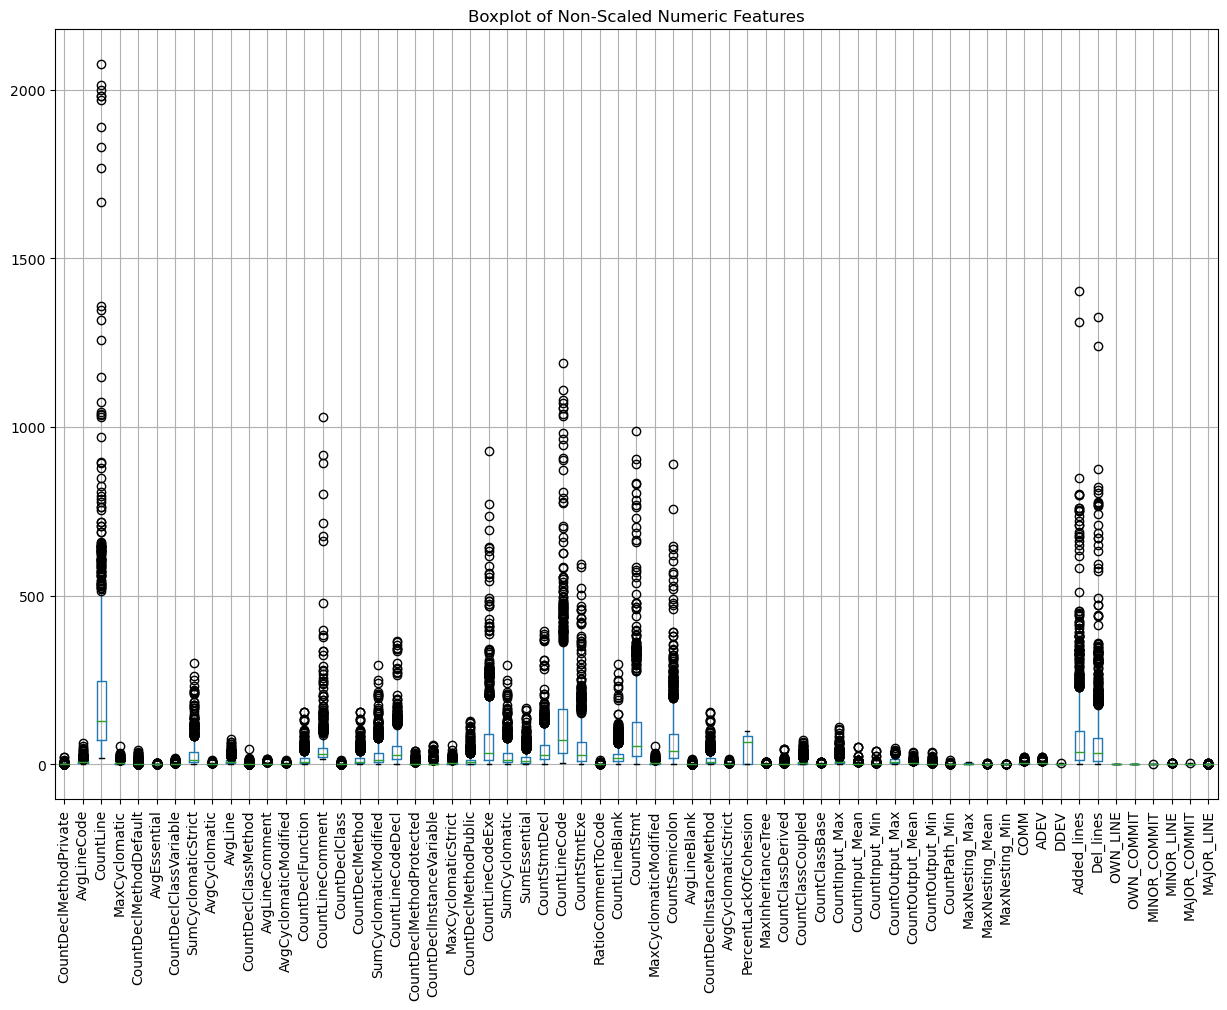

In [36]:
plt.figure(figsize=(15, 10))
X_train_balanced.drop(columns=['CountPath_Max', 'CountPath_Mean']).boxplot()
plt.title('Boxplot of Non-Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [37]:
X_train_balanced_scaled.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,1506.000000,1.506000e+03,1.506000e+03,1506.000000,1.506000e+03,1.506000e+03,1.506000e+03,1.506000e+03,1.506000e+03,1.506000e+03,...,1.506000e+03,1.506000e+03,1.506000e+03,1506.000000,1.506000e+03,1.506000e+03,1.506000e+03,1.506000e+03,1.506000e+03,1.506000e+03
mean,0.000000,-1.887232e-17,7.548927e-17,0.000000,-2.830848e-17,1.462605e-16,-9.436159e-18,3.774463e-17,7.548927e-17,-8.020735e-17,...,7.548927e-17,1.509785e-16,3.774463e-17,0.000000,6.039141e-16,1.887232e-16,-1.651328e-17,-1.132339e-16,1.132339e-16,1.887232e-17
std,1.000332,1.000332e+00,1.000332e+00,1.000332,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,...,1.000332e+00,1.000332e+00,1.000332e+00,1.000332,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00
min,-0.316906,-1.307163e+00,-7.940079e-01,-0.968242,-2.484864e-01,-3.038379e+00,-4.436229e-01,-7.716869e-01,-1.707184e+00,-1.295659e+00,...,-9.790904e-01,-2.584141e+00,-6.376249e-01,-0.607085,-2.236809e+00,-3.009264e+00,-2.577696e-02,-2.705049e+00,-2.595878e+00,-5.228689e-01
25%,-0.316906,-5.941004e-01,-5.572127e-01,-0.723335,-2.484864e-01,-1.785048e-01,-4.436229e-01,-5.956820e-01,-6.291887e-01,-6.417945e-01,...,-6.071151e-01,-6.829605e-01,-5.415754e-01,-0.511730,-8.651690e-01,-8.891831e-01,-2.577696e-02,-1.298349e+00,-6.841947e-01,-5.228689e-01
50%,-0.316906,-2.375691e-01,-3.025460e-01,-0.233523,-2.484864e-01,-1.785048e-01,-4.436229e-01,-3.903429e-01,-6.291887e-01,-2.494758e-01,...,-2.351398e-01,-6.829605e-01,-3.414722e-01,-0.325355,-9.763565e-02,7.194387e-01,-2.577696e-02,1.083514e-01,-6.841947e-01,-5.228689e-01
75%,-0.316906,2.972277e-01,2.235416e-01,0.256290,-2.484864e-01,-1.785048e-01,1.249695e-01,2.843426e-01,4.488069e-01,2.736158e-01,...,5.088109e-01,1.218220e+00,1.447785e-01,0.060398,7.811604e-01,8.540903e-01,-2.577696e-02,1.083514e-01,1.227489e+00,-5.228689e-01
max,15.102261,9.923572e+00,8.387394e+00,12.746511,1.216909e+01,8.401117e+00,1.092823e+01,8.057894e+00,1.338475e+01,8.512309e+00,...,7.204367e+00,5.020580e+00,1.057616e+01,10.887499,1.652844e+00,8.540903e-01,3.879433e+01,2.921752e+00,5.050855e+00,6.280073e+00


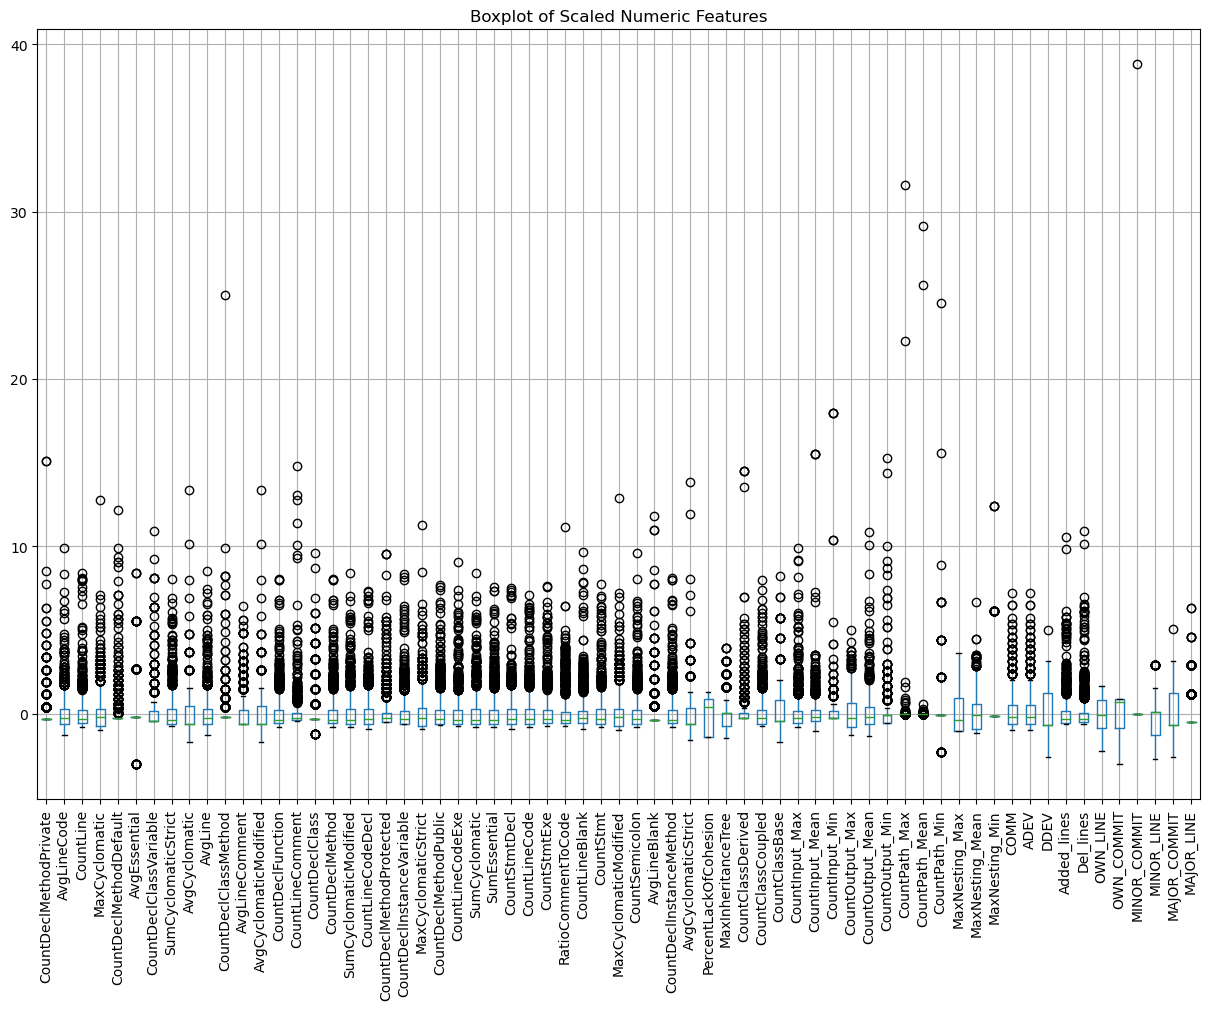

In [38]:
plt.figure(figsize=(15, 10))
X_train_balanced_scaled.boxplot()
plt.title('Boxplot of Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [39]:
# Export the balanced and scaled training set to CSV files
X_train_balanced_scaled.to_csv('../classification/hcbou/activemq-5.0.0-hcbou-train-features-balanced-scaled.csv', index=False)
y_train_balanced.to_csv('../classification/hcbou/activemq-5.0.0-hcbou-train-labels-balanced.csv', index=False)
X_test_scaled.to_csv('../classification/hcbou/activemq-5.0.0-hcbou-test-features-scaled.csv', index=False)
y_test.to_csv('../classification/hcbou/activemq-5.0.0-hcbou-test-labels.csv', index=False)